In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [10]:
def train_model(net, loss_fn, batchsize, trainset, valset, optimizer, num_epochs):

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=2)

    valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize,
                                         shuffle=False, num_workers=2)
    train_accuracies = []; val_accuracies = []
    train_losses = []; val_losses = []
    
    N = num_epochs
    net = net.cuda()
    loss_fn = loss_fn.cuda()

    for epoch in range(N):  # loop over the dataset multiple times
        correct = 0.0
        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, _, _ = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            max_scores, max_labels = outputs.max(1)
            correct += (max_labels == labels).sum().item()
            if (i+1) % (20) == 0:    # print every 10 mini-batches
                print('Train: [%d, %5d] loss: %.3f Accuracy: %.4f' %
                      (epoch + 1, i + 1, running_loss / i+1, correct / ((i+1)*batchsize)))
                running_loss = 0.0
        
        train_accuracies.append(correct / len(trainset))
        train_losses.append(running_loss / (i + 1))  

        net.eval()
        correct = 0
        running_loss = 0
        for i, data in enumerate(valloader, 0):
            inputs, labels, _, _ = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = net(inputs)
            running_loss += loss_fn(outputs, labels).item()

            max_scores, max_labels = outputs.max(1)
            correct += (max_labels == labels).sum().item()

        print('Validation: [%d, %5d] loss: %.3f Accuracy: %.4f' % 
              (epoch + 1, i + 1, running_loss / i+1, correct / ((i+1)*batchsize)))
        
        val_accuracies.append(correct / len(valset))
        val_losses.append(running_loss / (i + 1))
            

    print('Finished Training')

In [8]:
import torch.utils.data
import json, os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class UVaBuildinglabel(torch.utils.data.Dataset):
    def __init__(self, image_path, annotation_filepath, transform = None):
        super(UVaBuildinglabel, self).__init__()
        
        print('Loading data...')
        data = pd.read_csv(annotation_filepath)              #json.load(open(annotation_filepath, 'rb'))
        
        self.transform = transforms.Compose(
        [transforms.Resize(320),  # 1. Resize smallest side to 256.
        transforms.RandomCrop(320), # 2. Crop random square of 224x224 pixels.
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])
        
        self.image_path = image_path    # storing image path. 
        
        
        # get the image pixel values and labels
        image_ids = data.iloc[:, 0 ]
        label_ids = data.iloc[:, 1]
        label_names = data.iloc[:, 2]

        self.image_ids = data.iloc[:, 0 ] #[img_name for (img_id, img_name) in paired_id_names]
        self.image_labels = data.iloc[:, 1]   #[img_id for (img_id, img_name) in paired_id_names]
        self.image_classes= data.iloc[:, 2]


        print(image_ids[0])
        print(label_ids[0])
        print(label_names)

        
    def __getitem__(self, index):
        image_name = self.image_ids[index]
        img_ = Image.open(open(os.path.join(self.image_path, image_name), 'rb'))
        img_ = img_.convert("RGB")
        if self.transform:
            img_ = self.transform(img_)
        label_ = self.image_labels[index]
        class_name= self.image_classes[index]
        return img_, label_,image_name,class_name
    
    def __len__(self):
        return len(self.image_ids)
       
      
# You can unnormalize the transformation of torch's transforms.normalize 
# with this custom transformation.
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


trainset = UVaBuildinglabel('DATA', 'trainSet.csv')
valset = UVaBuildinglabel('DATA', 'valSet.csv')

Loading data...
alderman1.jpg
0
0      Alderman Library
1      Alderman Library
2      Alderman Library
3      Alderman Library
4      Alderman Library
             ...       
409       Wilsdorf Hall
410       Wilsdorf Hall
411       Wilsdorf Hall
412       Wilsdorf Hall
413       Wilsdorf Hall
Name: name, Length: 414, dtype: object
Loading data...
alderman9.jpg
0
0     Alderman Library
1     Alderman Library
2     Alderman Library
3     Alderman Library
4          Alumni Hall
            ...       
88       Wilsdorf Hall
89       Wilsdorf Hall
90       Wilsdorf Hall
91       Wilsdorf Hall
92       Wilsdorf Hall
Name: name, Length: 93, dtype: object


In [33]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
resnet = models.resnet50(pretrained = True)
resnet.fc = nn.Linear(2048, len(trainset.image_classes))
optimizer = optim.SGD(resnet.parameters(), lr=5e-4, momentum=0.9, weight_decay=1e-5)
#optimizer = optim.SGD(resnet.parameters(), lr=1e-4, momentum=0.9)

train_model(resnet, loss_fn, 4, trainset, valset, optimizer, 5)

Train: [1,    20] loss: 7.011 Accuracy: 0.0500
Train: [1,    40] loss: 3.261 Accuracy: 0.0312
Train: [1,    60] loss: 2.137 Accuracy: 0.0583
Train: [1,    80] loss: 1.795 Accuracy: 0.0750
Train: [1,   100] loss: 1.552 Accuracy: 0.0850
Validation: [1,    24] loss: 3.631 Accuracy: 0.3438
Train: [2,    20] loss: 3.720 Accuracy: 0.3250
Train: [2,    40] loss: 2.319 Accuracy: 0.3312
Train: [2,    60] loss: 1.740 Accuracy: 0.3750
Train: [2,    80] loss: 1.535 Accuracy: 0.4000
Train: [2,   100] loss: 1.449 Accuracy: 0.4025
Validation: [2,    24] loss: 2.664 Accuracy: 0.5729
Train: [3,    20] loss: 3.083 Accuracy: 0.5375
Train: [3,    40] loss: 1.937 Accuracy: 0.5250
Train: [3,    60] loss: 1.523 Accuracy: 0.5750
Train: [3,    80] loss: 1.382 Accuracy: 0.6125
Train: [3,   100] loss: 1.314 Accuracy: 0.6125
Validation: [3,    24] loss: 1.906 Accuracy: 0.8438
Train: [4,    20] loss: 2.240 Accuracy: 0.7750
Train: [4,    40] loss: 1.578 Accuracy: 0.8063
Train: [4,    60] loss: 1.380 Accuracy: 0.800

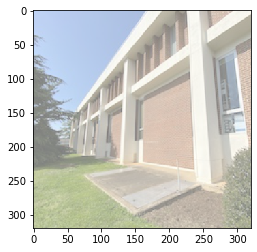

GroundTruth:  ('Mechanical Building',)
Predicted:  Mechanical Building


In [35]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

classes = ['Alderman Library', 'Alumni Hall', 'Aquatic & Fitness Center', 'Chemical Engineering Building', 'John Paul Jones Arena', 
           'Law School Building', 'Mechanical Building', 'Memorial Gym', 'Monroe Hall', 
           'Newcomb Hall', 'North Grounds Gym', 'Old Cabell Hall', 'Olsson Hall', 
           'Physics Building', 'Rice Hall', 'The Rotunda', 'Scott Stadium', 'Slaughter Recreation',
           'Thornton Hall', 'Wilsdorf Hall']

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#do some predictions
trainsetLoader = DataLoader(trainset, shuffle=True)
valsetLoader = DataLoader(valset, shuffle=True)

dataiter = iter(valsetLoader)
images, labels, image_name, class_name = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', class_name)

images = images.cuda()
output = resnet(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', classes[predicted.item()])


In [38]:
loss_fn = nn.CrossEntropyLoss()
mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet.fc = nn.Linear(2048, len(trainset.image_classes))
optimizer = optim.SGD(mobilenet.parameters(), lr=5e-4, momentum=0.9, weight_decay=1e-5)
#optimizer = optim.SGD(resnet.parameters(), lr=1e-4, momentum=0.9)

train_model(mobilenet, loss_fn, 4, trainset, valset, optimizer, 5)

Train: [1,    20] loss: 9.099 Accuracy: 0.0500
Train: [1,    40] loss: 3.690 Accuracy: 0.1562
Train: [1,    60] loss: 2.131 Accuracy: 0.2167
Train: [1,    80] loss: 1.432 Accuracy: 0.3094
Train: [1,   100] loss: 1.333 Accuracy: 0.3625
Validation: [1,    24] loss: 2.100 Accuracy: 0.7292
Train: [2,    20] loss: 1.826 Accuracy: 0.7750
Train: [2,    40] loss: 1.565 Accuracy: 0.7500
Train: [2,    60] loss: 1.380 Accuracy: 0.7375
Train: [2,    80] loss: 1.150 Accuracy: 0.7562
Train: [2,   100] loss: 1.139 Accuracy: 0.7700
Validation: [2,    24] loss: 1.462 Accuracy: 0.8542
Train: [3,    20] loss: 1.401 Accuracy: 0.9125
Train: [3,    40] loss: 1.208 Accuracy: 0.8938
Train: [3,    60] loss: 1.135 Accuracy: 0.8958
Train: [3,    80] loss: 1.104 Accuracy: 0.9000
Train: [3,   100] loss: 1.078 Accuracy: 0.9025
Validation: [3,    24] loss: 1.328 Accuracy: 0.9062
Train: [4,    20] loss: 1.437 Accuracy: 0.9125
Train: [4,    40] loss: 1.135 Accuracy: 0.9187
Train: [4,    60] loss: 1.092 Accuracy: 0.916

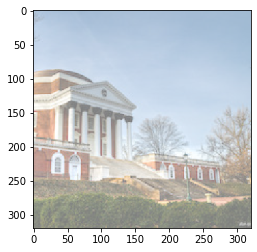

GroundTruth:  ('The Rotunda',)
Predicted:  The Rotunda


In [37]:
#do some predictions
trainsetLoader = DataLoader(trainset, shuffle=True)
valsetLoader = DataLoader(valset, shuffle=True)

dataiter = iter(valsetLoader)
images, labels, image_name, class_name = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', class_name)

images = images.cuda()
output = mobilenet(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', classes[predicted.item()])

In [40]:
loss_fn = nn.CrossEntropyLoss()
alexnet = models.alexnet(pretrained=True)
alexnet.classifier[6] = nn.Linear(4096, len(trainset.image_classes))
optimizer = optim.SGD(alexnet.parameters(), lr=5e-4, momentum=0.9, weight_decay=1e-5)
#optimizer = optim.SGD(resnet.parameters(), lr=1e-4, momentum=0.9)

train_model(alexnet, loss_fn, 4, trainset, valset, optimizer, 5)

Train: [1,    20] loss: 6.020 Accuracy: 0.0750
Train: [1,    40] loss: 2.807 Accuracy: 0.0938
Train: [1,    60] loss: 1.999 Accuracy: 0.1333
Train: [1,    80] loss: 1.639 Accuracy: 0.1625
Train: [1,   100] loss: 1.386 Accuracy: 0.2275
Validation: [1,    24] loss: 2.681 Accuracy: 0.4583
Train: [2,    20] loss: 2.874 Accuracy: 0.4750
Train: [2,    40] loss: 1.771 Accuracy: 0.4813
Train: [2,    60] loss: 1.355 Accuracy: 0.5583
Train: [2,    80] loss: 1.296 Accuracy: 0.5781
Train: [2,   100] loss: 1.187 Accuracy: 0.6000
Validation: [2,    24] loss: 1.893 Accuracy: 0.7292
Train: [3,    20] loss: 1.804 Accuracy: 0.7375
Train: [3,    40] loss: 1.413 Accuracy: 0.7562
Train: [3,    60] loss: 1.293 Accuracy: 0.7542
Train: [3,    80] loss: 1.187 Accuracy: 0.7500
Train: [3,   100] loss: 1.099 Accuracy: 0.7675
Validation: [3,    24] loss: 1.750 Accuracy: 0.7708
Train: [4,    20] loss: 2.241 Accuracy: 0.6375
Train: [4,    40] loss: 1.270 Accuracy: 0.7438
Train: [4,    60] loss: 1.259 Accuracy: 0.750

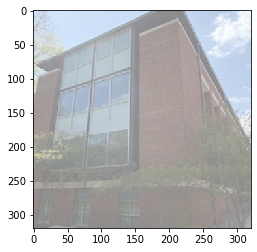

GroundTruth:  ('Wilsdorf Hall',)
Predicted:  Wilsdorf Hall


In [43]:
#do some predictions
trainsetLoader = DataLoader(trainset, shuffle=True)
valsetLoader = DataLoader(valset, shuffle=True)

dataiter = iter(valsetLoader)
images, labels, image_name, class_name = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', class_name)

images = images.cuda()
output = mobilenet(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', classes[predicted.item()])